# Fruit Freshness Classification Model Building
## B21-CAP0354

## Import libraries

In [ ]:
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import random
import pickle

In [ ]:
# Check whether GPU is available (Colab has TPU so we might be using it)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Mounting Google Drive to Colab (using Bangkit account)
from google.colab import drive
from google.colab import files

drive.mount('/gdrive')
# files.upload()

Mounted at /gdrive


In [ ]:
import os
os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/Kaggle'

## Import datasets

In [ ]:
os.chdir('/gdrive/MyDrive/Kaggle')

!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification
# !kaggle datasets download -d jorgebailon/fruits-vegetables

os.chdir('/content')

fruits-fresh-and-rotten-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


### Fruits fresh and rotten

In [ ]:
!cp '/gdrive/MyDrive/Kaggle/fruits-fresh-and-rotten-for-classification.zip' .
!unzip -q 'fruits-fresh-and-rotten-for-classification.zip'
!rm 'fruits-fresh-and-rotten-for-classification.zip'

In [ ]:
os.chdir('/content/dataset')
!rm -rf 'dataset'

In [ ]:
os.chdir('/content')
!cp '/gdrive/MyDrive/Kaggle/lemonDataset.zip' .
!unzip -q 'lemonDataset.zip'
!rm 'lemonDataset.zip'

### Fruits & vegetables (unclassified for freshness)

In [ ]:
# !cp '/gdrive/MyDrive/Kaggle/fruits-vegetables.zip' .
# !unzip -q '/gdrive/MyDrive/Kaggle/fruits-vegetables.zip'
# !rm 'fruits-vegetables.zip'

## Managing dataset folders

### Checking amount of images

In [ ]:
class_names = sorted(os.listdir('/content/dataset/train/'))
print(class_names)

['freshapples', 'freshbanana', 'freshlemon', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenlemon', 'rottenoranges']


In [ ]:
def list_dir(class_names, slice='train'):
  return os.listdir('/content/dataset/{}/{}'.format(slice, class_names))

for i in class_names:
  print(i)
  print(len(list_dir(i, 'train')))
  print(len(list_dir(i, 'test')))

freshapples
1354
395
freshbanana
1264
381
freshlemon
240
200
freshoranges
1172
388
rottenapples
1873
601
rottenbanana
1779
530
rottenlemon
232
180
rottenoranges
1276
403


## Visualizing images

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 6

pic_index = 0 # Index for iterating over images

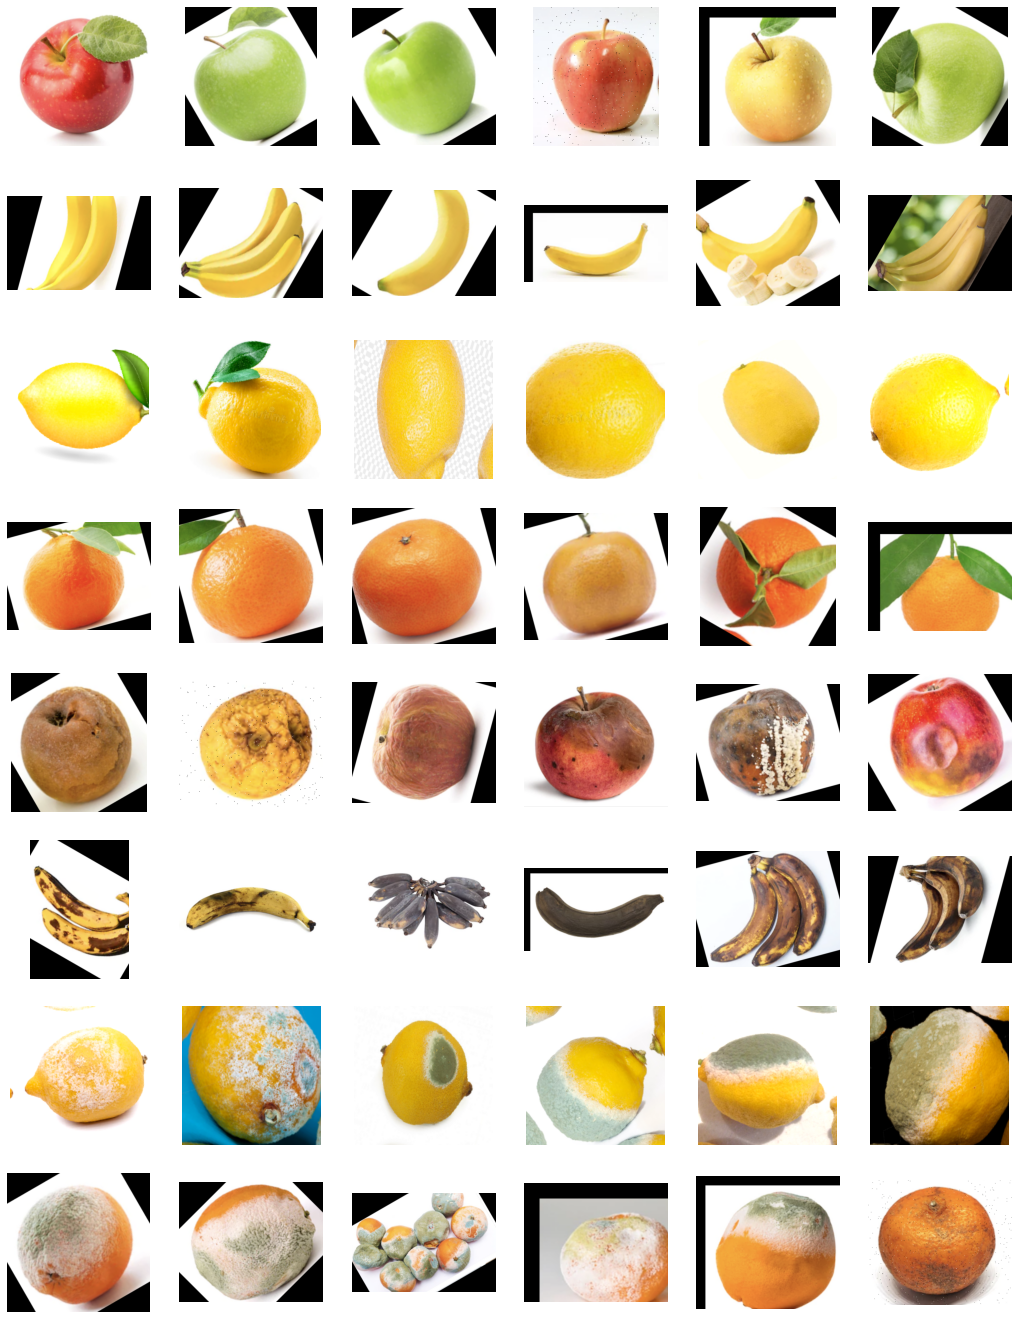

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

dirs = []

for i in class_names:
  path = '/content/dataset/train/{}/'.format(i)
  dir = list_dir(i, 'train')
  for fileName in dir[pic_index:pic_index+6]:
    dirs.append(path+fileName)

pic_index+=6

for i, img_path in enumerate(dirs):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Shuffling training data for validation (Probably not used)



In [ ]:
try:
  os.mkdir('/content/dataset/validation')
except:
  print('Folder already available')

In [ ]:
from shutil import copyfile

def create_validation(SOURCE, DEST, SPLIT_SIZE):
    valid_data = []
    for file in os.listdir(SOURCE):
        filename = SOURCE + file
        if os.path.getsize(filename) > 0:
            valid_data.append(file)
    
    train_size = int(SPLIT_SIZE * len(valid_data))
    validation_size = int((1-SPLIT_SIZE) * len(valid_data))
    randomized = random.sample(valid_data, len(valid_data))
    training = randomized[:train_size]
    testing = randomized[-(validation_size+1):]
        
    for i in testing:
        sourceFile = SOURCE + i
        target = DEST + i
        copyfile(sourceFile, target)
        os.remove(sourceFile)

In [ ]:
SOURCE = '/content/dataset/train/'
DEST = '/content/dataset/validation/'
SPLIT_SIZE = 0.8

for name in class_names:
  src = SOURCE + name + '/'
  trg = DEST + name + '/'
  try:
    os.mkdir(trg)
  except:
    print('Validation directory already exists')
  create_validation(src, trg, SPLIT_SIZE)

In [ ]:
for i in class_names:
  print(i)
  print(len(list_dir(i, 'train')))
  print(len(list_dir(i, 'validation')))
  print(len(list_dir(i, 'test')))

freshapples
1354
339
395
freshbanana
1264
317
381
freshlemon
240
60
200
freshoranges
1172
294
388
rottenapples
1873
469
601
rottenbanana
1779
445
530
rottenlemon
232
58
180
rottenoranges
1276
319
403


## Pre-process train & test images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.5, 1.0],
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_dir = '/content/dataset/train/'
test_dir = '/content/dataset/test/'
validation_dir = '/content/dataset/validation/'

train_flow = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical',
)
validation_flow = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode='categorical',
)
test_flow = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224,224),
    shuffle=False,
    class_mode='categorical',
)

train_steps = 9190 // 64
val_steps = 2301 // 32
test_steps = 3078 // 32

Found 9190 images belonging to 8 classes.
Found 2301 images belonging to 8 classes.
Found 3078 images belonging to 8 classes.


## Model Building
Using Transfer Learning to reduce training time, and improve accuracy

In [ ]:
# Model selections
# https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
# https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5

PRETRAINED_MODEL = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'
IMAGE_SIZE = (224, 224, 3)
OUTPUT_SHAPE = [1280]

In [ ]:
model = tf.keras.Sequential(
    [
     hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
                    input_shape=IMAGE_SIZE,
                    output_shape=OUTPUT_SHAPE,
                    trainable=False,
                    ),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(units=512, activation='relu'),
     tf.keras.layers.Dense(units=8, activation='softmax'),
    ]
)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0015), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 4,886,408
Trainable params: 659,976
Non-trainable params: 4,226,432
_________________________________________________________________


In [ ]:
model2 = tf.keras.Sequential(
    [
     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=IMAGE_SIZE),
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(units=256, activation='relu'),
     tf.keras.layers.Dropout(0.1),
     tf.keras.layers.Dense(units=8, activation='softmax')
    ]
)

model2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)       

### Creating callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.985):
      print('Target accuracy acquired!')
      self.model.stop_training = True

### Model fitting and evaluating

In [ ]:
callbacks = myCallback()
history = model.fit(train_flow, epochs=10, verbose=1, validation_data=validation_flow, callbacks=[callbacks], steps_per_epoch=train_steps, validation_steps=val_steps)

Epoch 1/10
143/143 [==============================] - 178s 1s/step - loss: 0.2830 - accuracy: 0.9079 - val_loss: 0.0731 - val_accuracy: 0.9758
Epoch 2/10
143/143 [==============================] - 141s 989ms/step - loss: 0.0493 - accuracy: 0.9837 - val_loss: 0.0474 - val_accuracy: 0.9833
Epoch 3/10
143/143 [==============================] - 141s 989ms/step - loss: 0.0267 - accuracy: 0.9914 - val_loss: 0.0281 - val_accuracy: 0.9894
Target accuracy acquired!


Text(0.5, 1.0, 'Accuracy')

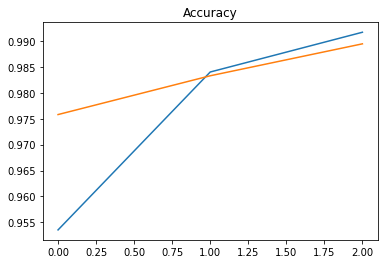

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

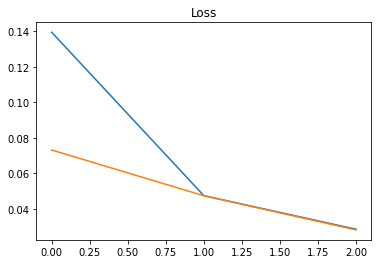

In [ ]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss')

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.955):
      print('Target accuracy acquired!')
      self.model.stop_training = True

In [ ]:
history = model2.fit(train_flow, epochs=25, verbose=1, validation_data=validation_flow, callbacks=[callbacks], steps_per_epoch=train_steps, validation_steps=val_steps)

Epoch 1/25
143/143 [==============================] - 142s 980ms/step - loss: 1.4146 - accuracy: 0.4694 - val_loss: 0.6427 - val_accuracy: 0.7852
Epoch 2/25
143/143 [==============================] - 140s 981ms/step - loss: 0.4798 - accuracy: 0.8262 - val_loss: 0.3283 - val_accuracy: 0.8873
Epoch 3/25
143/143 [==============================] - 141s 983ms/step - loss: 0.3760 - accuracy: 0.8680 - val_loss: 0.3130 - val_accuracy: 0.8939
Epoch 4/25
143/143 [==============================] - 141s 983ms/step - loss: 0.3066 - accuracy: 0.8920 - val_loss: 0.2657 - val_accuracy: 0.9049
Epoch 5/25
143/143 [==============================] - 141s 985ms/step - loss: 0.2730 - accuracy: 0.8977 - val_loss: 0.2263 - val_accuracy: 0.9199
Epoch 6/25
143/143 [==============================] - 141s 985ms/step - loss: 0.2268 - accuracy: 0.9194 - val_loss: 0.1933 - val_accuracy: 0.9261
Epoch 7/25
143/143 [==============================] - 141s 986ms/step - loss: 0.2309 - accuracy: 0.9158 - val_loss: 0.2051 -

Text(0.5, 1.0, 'Accuracy')

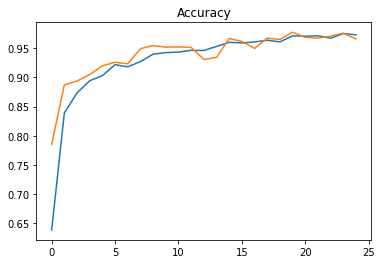

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

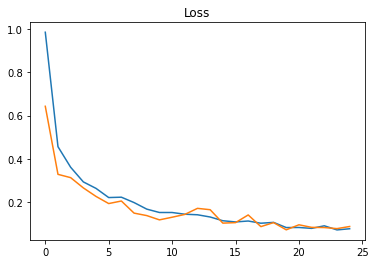

In [ ]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss')

In [ ]:
model.evaluate(test_flow, verbose=1)
model2.evaluate(test_flow, verbose=1)

97/97 [==============================] - 14s 147ms/step - loss: 0.2542 - accuracy: 0.9334


[0.2541653513908386, 0.9333983063697815]

## Testing model

In [ ]:
# from keras.preprocessing import image

# imageUpload = files.upload()

# print(sorted(class_names))
# for fn in imageUpload.keys():
#   path = fn
#   img = image.load_img(path, color_mode="rgb", target_size=(224,224), interpolation="nearest")
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)
#   x = x/255.0

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=8)
#   print(fn)
#   print(classes)
#   classes = model2.predict(images, batch_size=8)
#   print(classes)

Saving new_fresh_2.png to new_fresh_2.png
Saving new_fresh_5.png to new_fresh_5.png
Saving new_fresh_6.png to new_fresh_6.png
Saving new_fresh_7.png to new_fresh_7.png
['freshapples', 'freshbanana', 'freshlemon', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenlemon', 'rottenoranges']
new_fresh_2.png
[[1.9663214e-10 2.1354654e-09 9.9972457e-01 1.5132734e-06 8.6127966e-11
  1.6434401e-10 2.7356020e-04 2.6501354e-07]]
[[1.0251991e-06 5.9517828e-07 9.1019356e-01 7.8015665e-07 9.9255871e-05
  4.4115014e-09 8.9704379e-02 3.9659071e-07]]
new_fresh_5.png
[[2.1709727e-10 7.2492193e-11 9.9999964e-01 2.7130151e-10 1.5530304e-11
  4.5609420e-13 3.4632731e-07 9.4179716e-12]]
[[2.2470331e-16 3.4327927e-16 9.7778100e-01 5.0073418e-12 2.0824903e-13
  3.4274055e-21 2.2218999e-02 2.9001650e-17]]
new_fresh_6.png
[[2.3023722e-11 2.1025163e-11 9.9999928e-01 6.1714267e-08 9.8375075e-12
  3.2585764e-12 6.3145404e-07 1.5569852e-09]]
[[5.2992184e-17 6.8456271e-16 7.3657736e-02 6.8924098e-13 9.5370353e-

In [ ]:
print(sorted(class_names))

tests = [
         '/content/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.16.28 PM.png',
         '/content/dataset/test/freshbanana/Screen Shot 2018-06-12 at 9.54.43 PM.png',
         '/content/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.39.20 PM.png',
         '/content/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 8.56.01 PM.png',
         '/content/dataset/test/freshlemon/aug_0_3901467.png',
         '/content/dataset/test/rottenlemon/aug_0_8934045.png',
         '/content/dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.55.28 PM.png',
         '/content/dataset/test/rottenoranges/rotated_by_45_Screen Shot 2018-06-12 at 11.41.44 PM.png',
         '/content/dataset/test/freshoranges/rotated_by_75_Screen Shot 2018-06-12 at 11.58.50 PM.png',
         ]

predict_result = []
predict_result2 = []
percent = []
percent2 = []

for fn in tests:
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224,224), interpolation="nearest")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  images = np.vstack([x])
  classes = model.predict(images)
  print(fn)
  predict_result.append(np.argmax(classes))
  percent.append(max(classes[0]))
  classes = model2.predict(images)
  predict_result2.append(np.argmax(classes))
  percent2.append(max(classes[0]))

['freshapples', 'freshbanana', 'freshlemon', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenlemon', 'rottenoranges']
/content/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.16.28 PM.png
/content/dataset/test/freshbanana/Screen Shot 2018-06-12 at 9.54.43 PM.png
/content/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.39.20 PM.png
/content/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 8.56.01 PM.png
/content/dataset/test/freshlemon/aug_0_3901467.png
/content/dataset/test/rottenlemon/aug_0_8934045.png
/content/dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.55.28 PM.png
/content/dataset/test/rottenoranges/rotated_by_45_Screen Shot 2018-06-12 at 11.41.44 PM.png
/content/dataset/test/freshoranges/rotated_by_75_Screen Shot 2018-06-12 at 11.58.50 PM.png


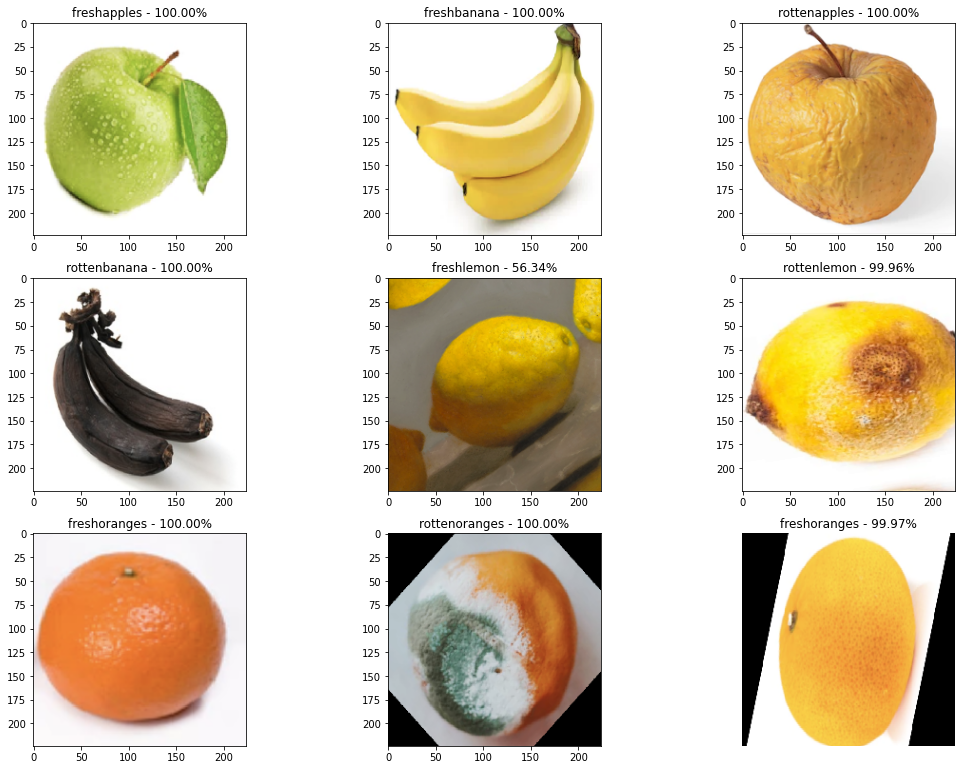

In [ ]:
plt.figure(figsize=(18, 18))

num_index = 0
for images in tests:
  plt.subplot((len(tests)/3)+1, 3, num_index+1)
  plt.imshow(image.load_img(images, color_mode="rgb", target_size=(224,224), interpolation="nearest"))
  plt.title("{} - {:0.2f}%".format(class_names[predict_result[num_index]], percent[num_index]*100))
  num_index += 1
plt.axis('off')
plt.show()

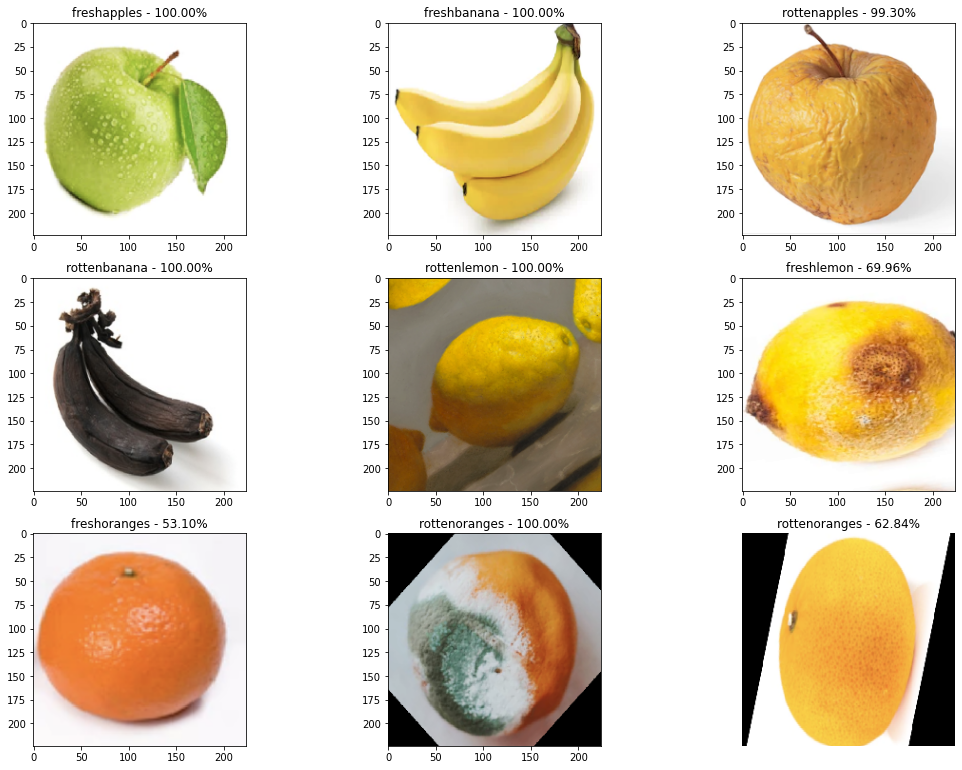

In [ ]:
plt.figure(figsize=(18, 18))

num_index = 0
for images in tests:
  plt.subplot((len(tests)/3)+1, 3, num_index+1)
  plt.imshow(image.load_img(images, color_mode="rgb", target_size=(224,224), interpolation="nearest"))
  plt.title("{} - {:0.2f}%".format(class_names[predict_result2[num_index]], percent2[num_index]*100))
  num_index += 1
plt.axis('off')
plt.show()

## Saving model & converting to TFLite format & create labels

In [ ]:
def save_model_func(model_var, model_name):
  os.chdir('/content')
  try:
    os.mkdir('models')
  except:
    pass
  model_var.save('models/{}'.format(model_name))

  converter = tf.lite.TFLiteConverter.from_saved_model('models/{}'.format(model_name))

  new_datagen = ImageDataGenerator(
    rescale=1./255
  )

  rep_flow = new_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
  )

  def representative_data_gen():
    for _ in range(300):
      img_with_label = rep_flow.next() # it returns (image and label) tuple
      yield [np.array(img_with_label[0], dtype=np.float32, ndmin=2)] # return only image
    
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # converter.representative_dataset = representative_data_gen
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # converter.inference_input_type = tf.uint8
  # converter.inference_output_type = tf.uint8

  tflite_model = converter.convert()

  with open('{}.tflite'.format(model_name), 'wb') as f:
    f.write(tflite_model)

  files.download('{}.tflite'.format(model_name))

  with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

  files.download('labels.txt')
  return tflite_model

In [ ]:
lite_model = save_model_func(model, 'mobilenetv3_edit_v1')
lite_model2 = save_model_func(model2, 'custom_model_v1')

INFO:tensorflow:Assets written to: models/mobilenetv3_edit_v1/assets
Found 3078 images belonging to 8 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: models/custom_model_v1/assets
Found 3078 images belonging to 8 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/mobilenetv3_edit_v1.zip /content/models/mobilenetv3_edit_v1
!zip -r /content/custom_model_v1.zip /content/models/custom_model_v1

  adding: content/models/mobilenetv3_edit_v1/ (stored 0%)
  adding: content/models/mobilenetv3_edit_v1/variables/ (stored 0%)
  adding: content/models/mobilenetv3_edit_v1/variables/variables.index (deflated 77%)
  adding: content/models/mobilenetv3_edit_v1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/models/mobilenetv3_edit_v1/saved_model.pb (deflated 92%)
  adding: content/models/mobilenetv3_edit_v1/assets/ (stored 0%)
  adding: content/models/custom_model_v1/ (stored 0%)
  adding: content/models/custom_model_v1/variables/ (stored 0%)
  adding: content/models/custom_model_v1/variables/variables.index (deflated 59%)
  adding: content/models/custom_model_v1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/models/custom_model_v1/saved_model.pb (deflated 89%)
  adding: content/models/custom_model_v1/assets/ (stored 0%)


## (Optional) Load model

In [ ]:
model = tf.keras.models.load_model('/gdrive/MyDrive/Kaggle/models/mobilenet_v1/mobilenetv3_edit_v1')
model2 = tf.keras.models.load_model('/gdrive/MyDrive/Kaggle/models/custom_model_v1/custom_model_v1')

lite_model = tf.lite.Interpreter(model_path='/gdrive/MyDrive/Kaggle/models/mobilenet_v1/mobilenetv3_edit_v1.tflite')
lite_model2 = tf.lite.Interpreter(model_path='/gdrive/MyDrive/Kaggle/models/custom_model_v1/custom_model_v1.tflite')

## Converting to TFLite format & create labels



In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model('models/project_model_v3')
# tflite_model = converter.convert()

# with open('model_v3.tflite', 'wb') as f:
#   f.write(tflite_model)

# files.download('model_v3.tflite')

# with open('labels.txt', 'w') as f:
#   f.write('\n'.join(class_names))

# files.download('labels.txt')

## Trying out the TFLite model

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model)
# interpreter = lite_model

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = []

rep_flow = test_datagen.flow_from_directory(
  test_dir,
  batch_size=1,
  target_size=(224,224),
  shuffle=True,
  class_mode='categorical',
)

test_labels, test_imgs = [], []
for _ in range(10):
  image_file = list(rep_flow.next())
  test_imgs.append(image_file[0])
  print(image_file[1])
  test_labels.append(np.argmax(image_file[1]))

  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    image_file[0] = image_file[0] / input_scale + input_zero_point
  
  image_file[0] = image_file[0].astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], image_file[0])
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])[0]
  predictions.append(output)

Found 3078 images belonging to 8 classes.
[[0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
        
    plt.xlabel("{} {:0.2f}% ({})".format(class_names[predicted_label],
                                         np.max(predictions_array)*100,
                                         class_names[true_label]))

<class 'numpy.int64'> <class 'numpy.int64'>


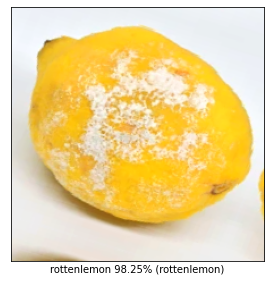

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 9 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

## Get TFLite model input and output shapes

In [ ]:
import tensorflow as tf
from google.colab import files
import numpy as np
from keras.preprocessing import image

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/mobilenetv3_edit_v1.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 224 224   3] <class 'numpy.float32'>

1 output(s):
[1 8] <class 'numpy.float32'>


In [ ]:
images = files.upload()

for image_file in images:
  img = image.load_img(image_file, color_mode="rgb", target_size=(224,224), interpolation="nearest")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  img_vstack = np.vstack([x])
  test_imgs.append(img_vstack)

Saving fresh_banana_1.jpg to fresh_banana_1.jpg


In [ ]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

images = files.upload()

test_imgs = []
predictions = []

for image_file in images:
  img = image.load_img(image_file, color_mode="rgb", target_size=(224,224), interpolation="nearest")
  x = image.img_to_array(img)
  print(x.shape)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  print(x.shape)
  img_vstack = np.vstack([x])
  print(img_vstack)
  print('========')
  test_imgs.append(img_vstack)

  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    img_vstack = img_vstack / input_scale + input_zero_point
  
  img_vstack = img_vstack.astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], img_vstack)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])[0]
  predictions.append(output)

Saving fresh_apple_1.jpg to fresh_apple_1 (6).jpg
Saving rotten_banana_1.jpg to rotten_banana_1 (6).jpg
(224, 224, 3)
(1, 224, 224, 3)
[[[[0.45882353 0.3372549  0.22352941]
   [0.47058824 0.3529412  0.21960784]
   [0.49019608 0.35686275 0.21960784]
   ...
   [0.15686275 0.15294118 0.14509805]
   [0.13725491 0.14509805 0.1254902 ]
   [0.11372549 0.12156863 0.10196079]]

  [[0.46666667 0.34509805 0.23137255]
   [0.47843137 0.36078432 0.22745098]
   [0.49411765 0.36078432 0.22352941]
   ...
   [0.16470589 0.16078432 0.15294118]
   [0.14901961 0.15686275 0.13725491]
   [0.1254902  0.13333334 0.11372549]]

  [[0.46666667 0.34509805 0.23137255]
   [0.47843137 0.36078432 0.22745098]
   [0.49803922 0.3647059  0.22745098]
   ...
   [0.16470589 0.16862746 0.14901961]
   [0.15686275 0.16470589 0.15294118]
   [0.13725491 0.14509805 0.13333334]]

  ...

  [[0.25882354 0.3137255  0.17254902]
   [0.25882354 0.30588236 0.16470589]
   [0.2509804  0.29411766 0.16078432]
   ...
   [0.34117648 0.28627452 

In [ ]:
import matplotlib.pyplot as plt

class_names = ['freshapples','freshbanana','freshlemon','freshoranges','rottenapples','rottenbanana','rottenlemon','rottenoranges']

def plot_image(i, predictions_array, img):
    predictions_array, img = predictions_array[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)

    print(predicted_label)
        
    plt.xlabel("{} {:0.2f}%".format(class_names[predicted_label],
                                         np.max(predictions_array)*100))

1


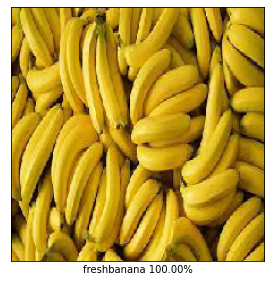

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:6, step:1}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(index, predictions, test_imgs)
plt.show()

## Get model weights

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/gdrive')

model = tf.keras.models.load_model('/gdrive/MyDrive/Kaggle/models/custom_model_v1/custom_model_v1')
model.save_weights('fruit_classification_custom')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
